# 1: Data Simulation

In [75]:
import numpy as np
import pandas as pd
import os, pdb, sys, pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# BASE DATASET
path = 'C://Users//cshul//Downloads//adult//adult.data'
df = pd.read_csv(path, header = None)
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
        'hours-per-week', 'native-country', 'income']
df.columns = cols
keeps = ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
         'hours-per-week', 'native-country', 'income']
df = df[keeps]
df['geq_50k'] = [1 if i == ' <=50K' else 0 for i in df['income']]
df = df.drop(['income'], axis = 1)
tr, te = train_test_split(df, test_size = 0.3, random_state = 42)
tr.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,geq_50k
19749,34,Self-emp-not-inc,9,Married-civ-spouse,Farming-fishing,Wife,White,Female,0,2179,12,United-States,1
1216,48,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688,0,40,United-States,0
27962,23,State-gov,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,30,United-States,1
23077,56,Local-gov,9,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,1
10180,17,Private,7,Never-married,Priv-house-serv,Own-child,White,Female,0,0,9,United-States,1


In [76]:
numCols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
import random
scalings = [] 
while len(scalings) < 10: 
    scalings.append([random.uniform(-15,15) for _ in range(5)])
tes = {} 
ct = 0 
for s in scalings: 
    ted = te.copy(deep = True)
    ted['age'] = [s[0] * i for i in ted['age']]
    ted['education-num'] = [s[1]*i for i in ted['education-num']]
    ted['capital-gain'] = [s[2]*i for i in ted['capital-gain']]
    ted['capital-loss'] = [s[3]*i for i in ted['capital-loss']]
    ted['hours-per-week'] = [s[4]*i for i in ted['hours-per-week']]
    tes[ct] = ted
    ct += 1
print(tes.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


# Train GBC

In [77]:
from catboost import CatBoostClassifier, Pool
import pandas as pd

cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
model = CatBoostClassifier(iterations=200, depth=4, learning_rate=0.05, loss_function = 'Logloss')
keeps = [i for i in tr.columns if i != 'geq_50k']
model.fit(tr[keeps], tr['geq_50k'], cat_features=cat_features)
tr['pred'] = model.predict(tr[keeps])
te['pred'] = model.predict(te[keeps])

# Predict on drifted data
for k in tes.keys(): 
    sub = tes[k]
    sub['pred'] = model.predict(sub[keeps])
    tes[k] = sub
tr.head()

0:	learn: 0.6477436	total: 53.5ms	remaining: 10.6s
1:	learn: 0.6077563	total: 98.3ms	remaining: 9.73s
2:	learn: 0.5734370	total: 145ms	remaining: 9.5s
3:	learn: 0.5420244	total: 195ms	remaining: 9.58s
4:	learn: 0.5156586	total: 252ms	remaining: 9.82s
5:	learn: 0.4941385	total: 308ms	remaining: 9.97s
6:	learn: 0.4753703	total: 361ms	remaining: 9.96s
7:	learn: 0.4590549	total: 404ms	remaining: 9.7s
8:	learn: 0.4429819	total: 447ms	remaining: 9.49s
9:	learn: 0.4314216	total: 500ms	remaining: 9.5s
10:	learn: 0.4193477	total: 553ms	remaining: 9.51s
11:	learn: 0.4125677	total: 595ms	remaining: 9.32s
12:	learn: 0.4035813	total: 649ms	remaining: 9.34s
13:	learn: 0.3951483	total: 699ms	remaining: 9.29s
14:	learn: 0.3881809	total: 786ms	remaining: 9.69s
15:	learn: 0.3825140	total: 843ms	remaining: 9.7s
16:	learn: 0.3779713	total: 894ms	remaining: 9.62s
17:	learn: 0.3734810	total: 938ms	remaining: 9.49s
18:	learn: 0.3695130	total: 994ms	remaining: 9.47s
19:	learn: 0.3651025	total: 1.04s	remaining

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,geq_50k,pred
19749,34,Self-emp-not-inc,9,Married-civ-spouse,Farming-fishing,Wife,White,Female,0,2179,12,United-States,1,1
1216,48,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688,0,40,United-States,0,0
27962,23,State-gov,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,30,United-States,1,1
23077,56,Local-gov,9,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,1,1
10180,17,Private,7,Never-married,Priv-house-serv,Own-child,White,Female,0,0,9,United-States,1,1


In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
vals = ['train', 'test'] + list(tes.keys())
vals = vals[::-1]

items = [tr, te]
for k in tes.keys(): 
    items.append(tes[k])

for f in items: 
    y, yp = f['geq_50k'], f['pred']
    print(vals[-1])
    vals.pop()
    print('accuracy: ' + str(accuracy_score(y,yp)))
    print('precision: ' + str(precision_score(y,yp)))
    print('recall: ' + str(recall_score(y,yp)))
    print('f1: ' + str(f1_score(y,yp)))
    print(confusion_matrix(y,yp))
    print('-------------------------------')

train
accuracy: 0.8699543699543699
precision: 0.8899918189255522
recall: 0.9451491456704315
f1: 0.916741573033708
[[ 3510  2017]
 [  947 16318]]
-------------------------------
test
accuracy: 0.8695874705701709
precision: 0.8920461753139668
recall: 0.9432595573440644
f1: 0.9169383231190508
[[1463  851]
 [ 423 7032]]
-------------------------------
0
accuracy: 0.7954754836728427
precision: 0.8107277075503929
recall: 0.9549295774647887
f1: 0.8769401330376939
[[ 652 1662]
 [ 336 7119]]
-------------------------------
1
accuracy: 0.7395843996314874
precision: 0.9410813723729118
recall: 0.7027498323272972
f1: 0.8046383044079252
[[1986  328]
 [2216 5239]]
-------------------------------
2
accuracy: 0.7631282628723514
precision: 0.7631282628723514
recall: 1.0
f1: 0.8656525777984208
[[   0 2314]
 [   0 7455]]
-------------------------------
3
accuracy: 0.7351827208516737
precision: 0.9436748086037186
recall: 0.6944332662642522
f1: 0.8000927285372073
[[2005  309]
 [2278 5177]]
-----------------

# Compute PE

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gudhi import RipsComplex, SimplexTree

res = {} 
for k in tes.keys(): 
    for w in [30]: 
        print("K: " + str(k))
        print("W: " + str(w))
        # Combine df and df_drifted
        df_combined = pd.concat([tr, tes[k]]).reset_index(drop=True)

        # Generate a time index
        df_combined['time'] = np.arange(len(df_combined))

        # Create a function to compute persistence diagrams
        def compute_persistence_diagrams(data):
            rips_complex = RipsComplex(points=data)
            simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
            simplex_tree.persistence()
            persistence_intervals = simplex_tree.persistence_intervals_in_dimension(1)
            return persistence_intervals

        # Create a function to compute persistence entropy
        def compute_persistence_entropy(diagrams):
            entropies = []
            for diagram in diagrams:
                lifetimes = diagram[:, 1] - diagram[:, 0]
                lifetimes = lifetimes[lifetimes > 0]
                if len(lifetimes) > 0:
                    p = lifetimes / lifetimes.sum()
                    entropy = -np.sum(p * np.log(p))
                else:
                    entropy = 0
                entropies.append(entropy)
            return entropies

        # Compute persistence entropy over time
        entropy_values = []

        for start in range(len(df_combined) - w + 1):
            window_data = df_combined[numCols].iloc[start:start + w].values
            persistence_diagrams = [compute_persistence_diagrams(window_data)]
            entropy_value = compute_persistence_entropy(persistence_diagrams)[0]
            entropy_values.append(entropy_value)
        df_combined['pe'] = [0]*(w-1) + entropy_values
        dfc = df_combined.copy(deep = True)
        res[str(k) + '-' + str(w)] = dfc

K: 0
W: 30
K: 1
W: 30
K: 2
W: 30
K: 3
W: 30
K: 4
W: 30
K: 5
W: 30
K: 6
W: 30
K: 7
W: 30
K: 8
W: 30
K: 9
W: 30


In [80]:
import pickle
with open('res.pickle', 'wb') as file: 
    pickle.dump(res, file)

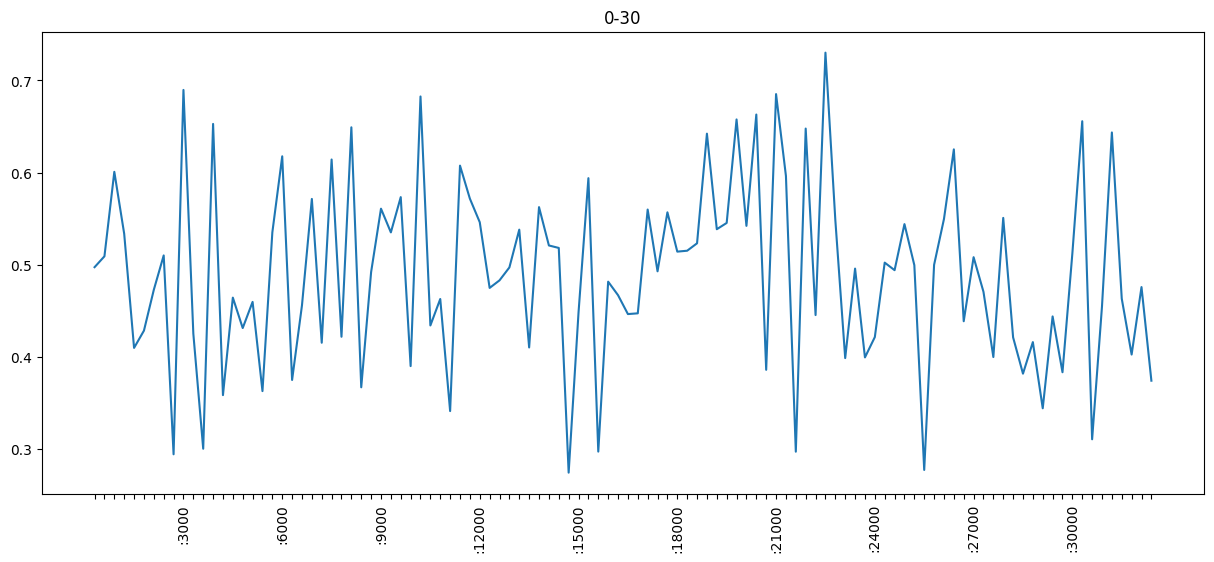

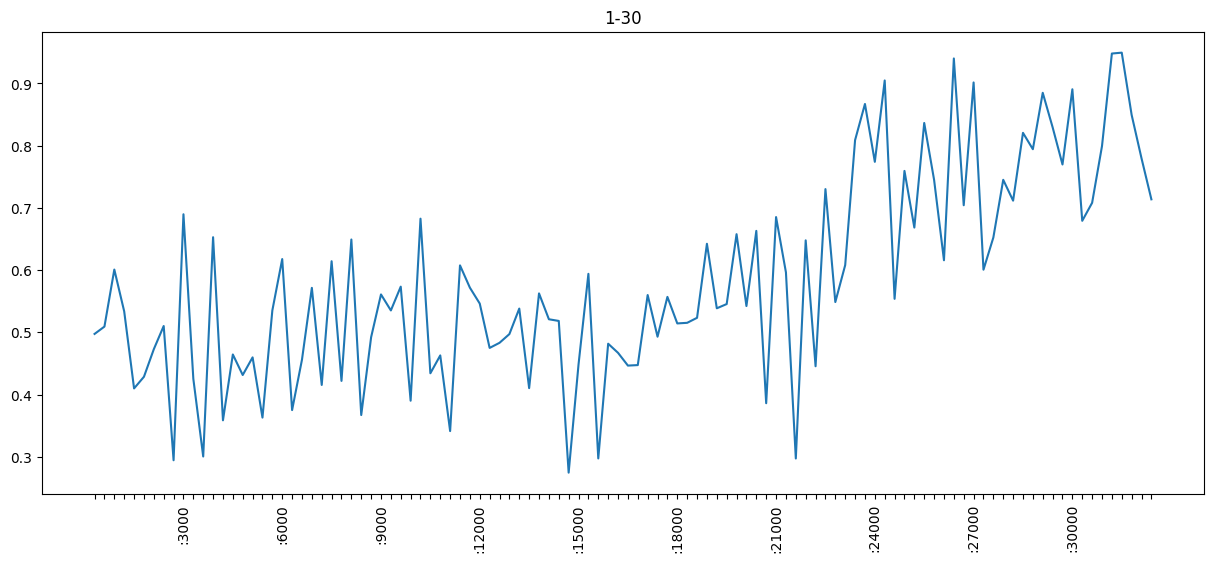

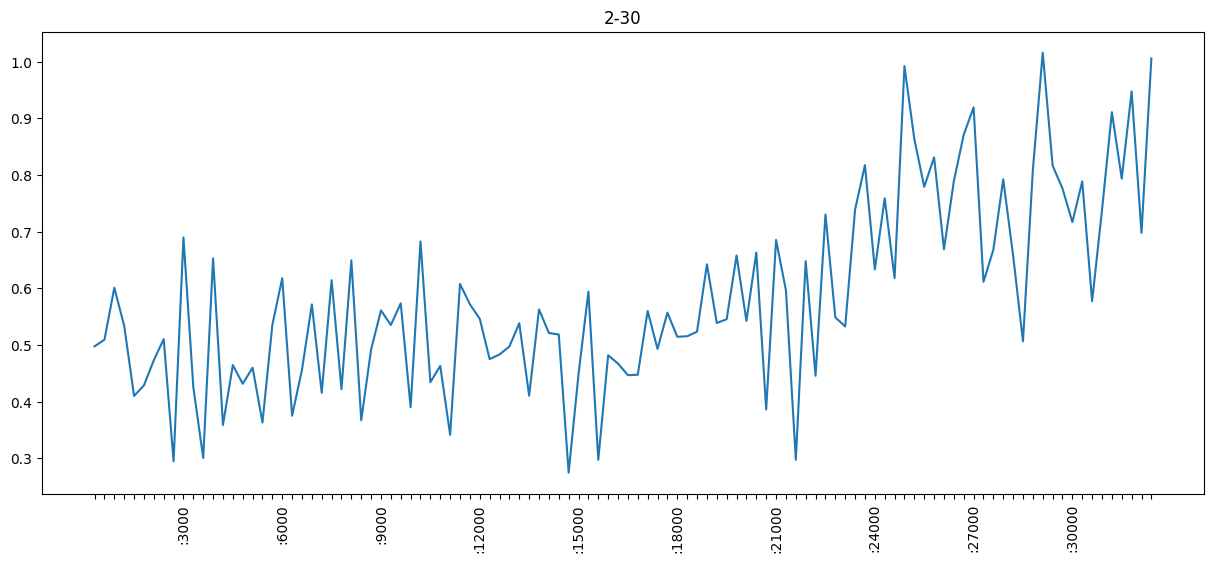

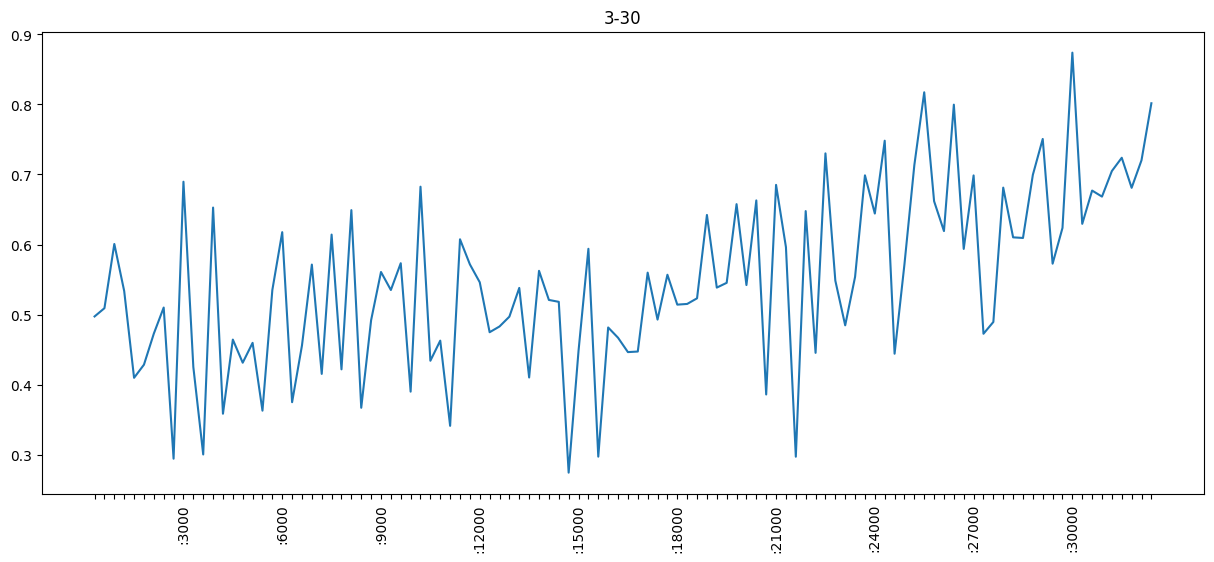

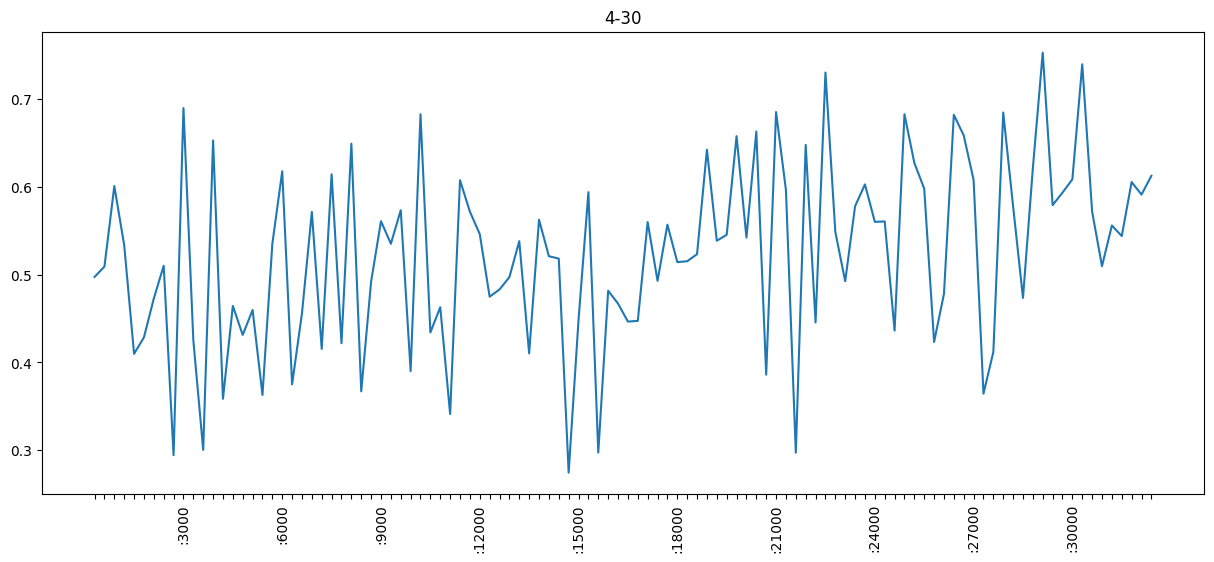

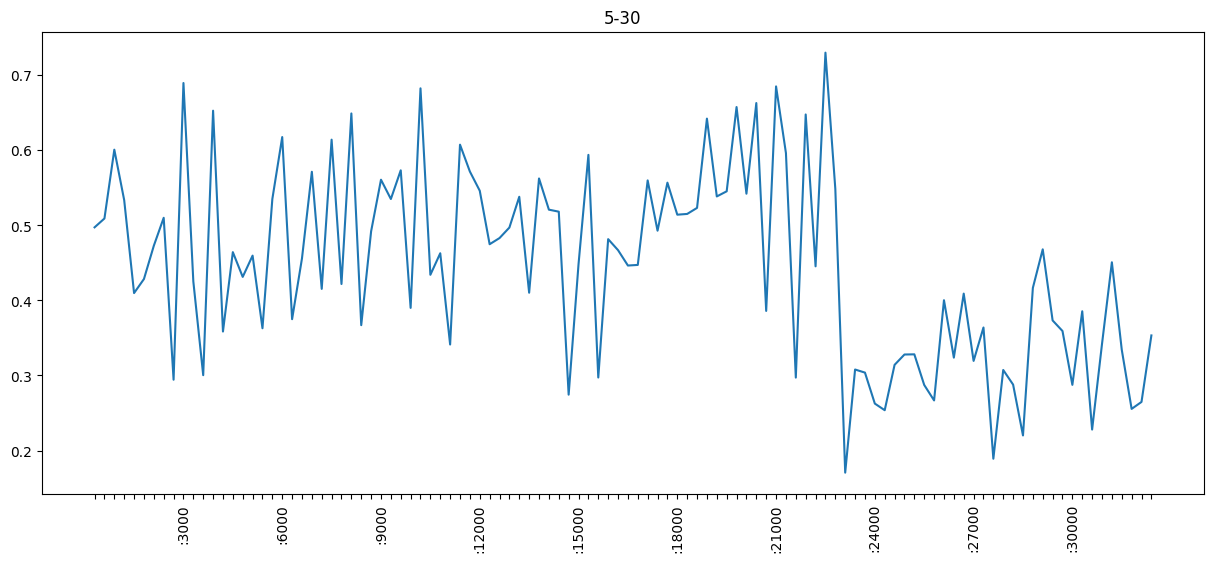

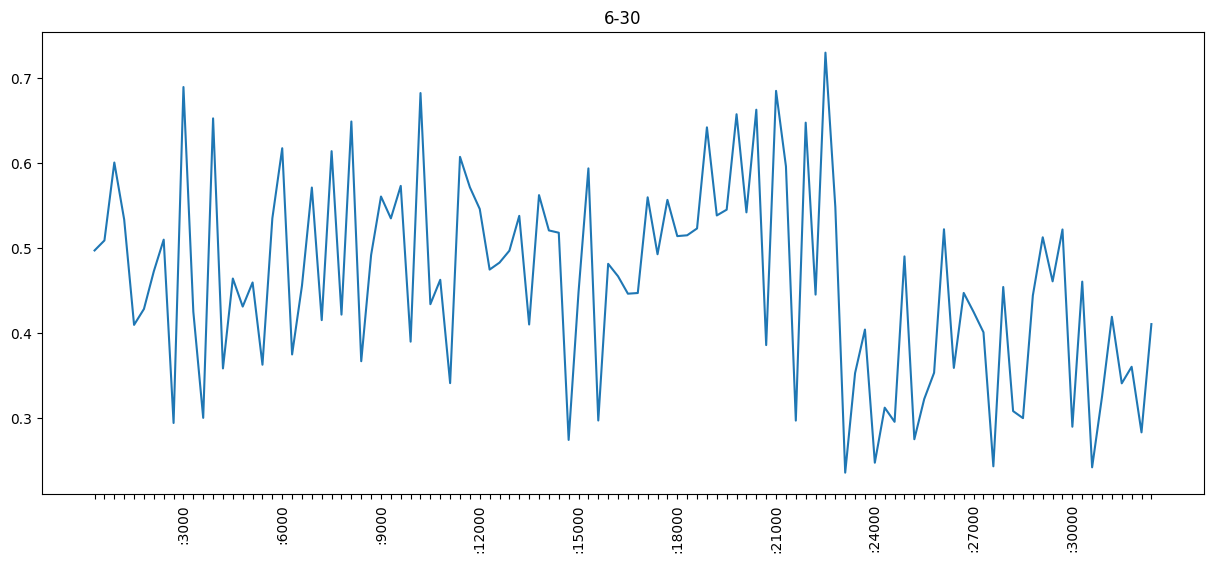

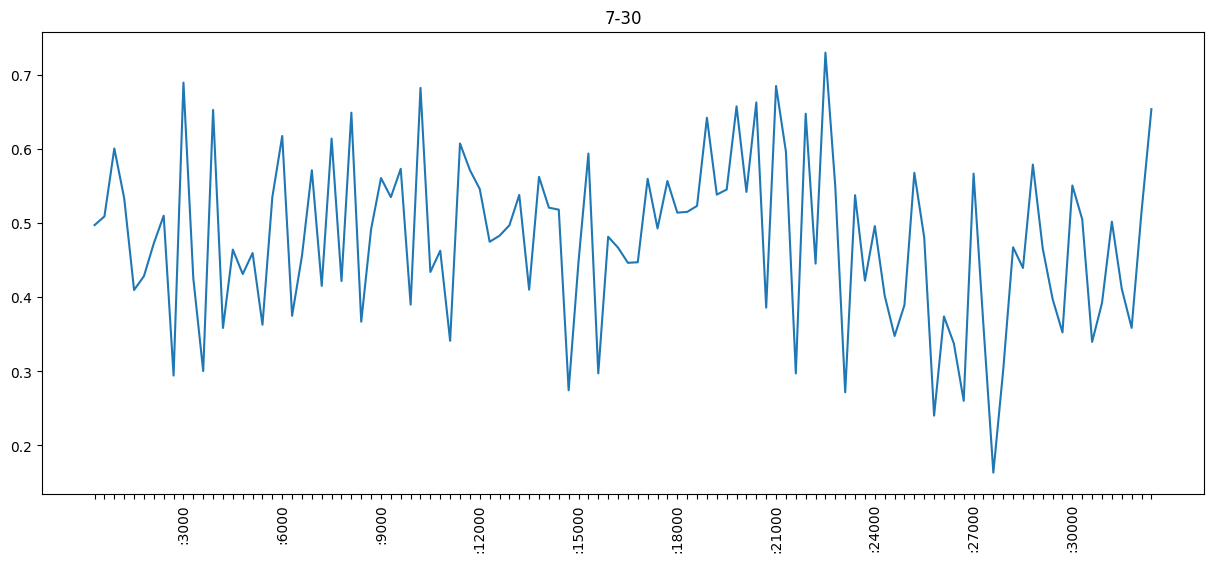

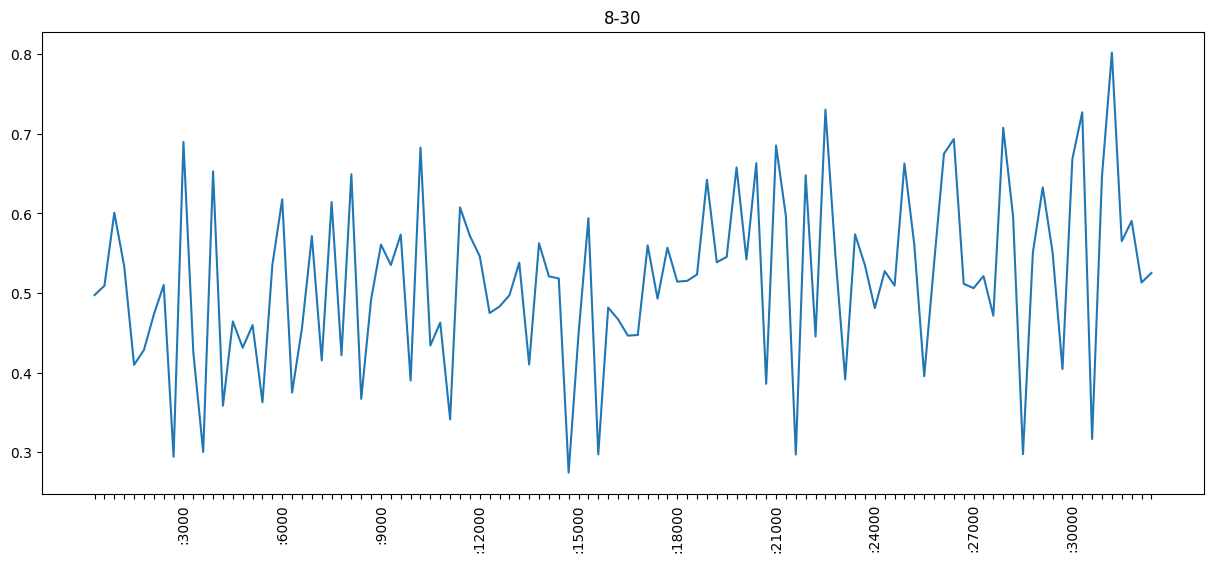

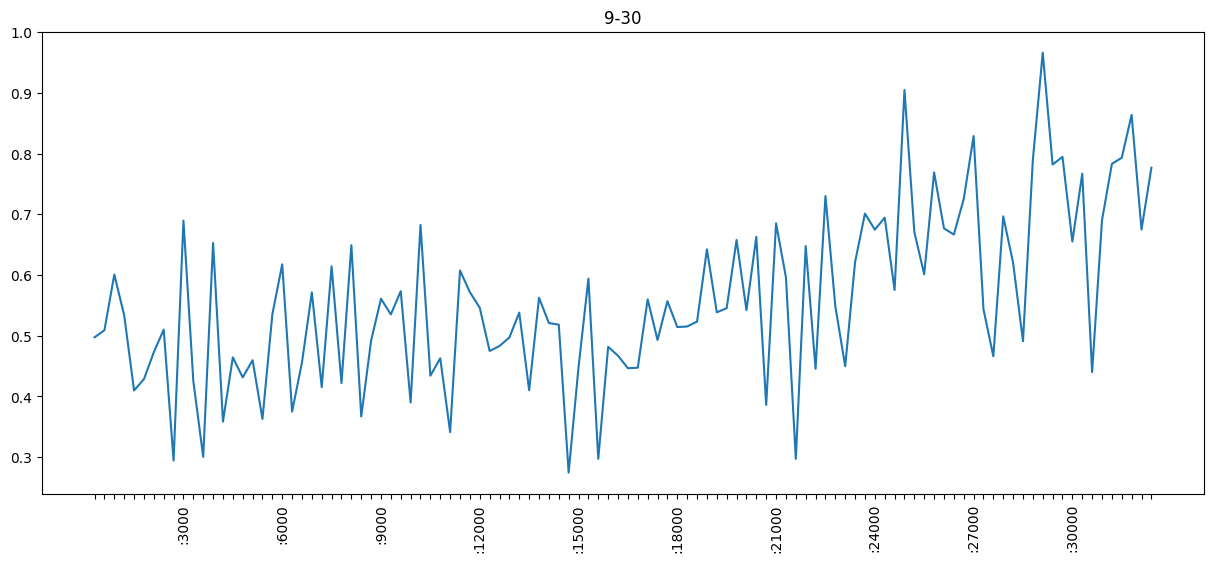

In [83]:
iter_val = 300
for_plots = {} 
for k in res.keys(): 
    sub = res[k]
    avgs, idx = [], []
    start, stop = 0, iter_val
    while stop < len(sub): 
        vals = list(sub['pe'])[start:stop]
        avgs.append(np.mean(vals))
        idx.append(':' + str(stop))
        start = stop
        stop += iter_val
    plt.figure(figsize=(15,6))
    plt.plot(range(len(avgs)), avgs, label = 'average_pe')
    plt.xticks(range(len(avgs)), [i if int(i.split(':')[-1])%1000 == 0 else '' for i in idx], rotation = 90)
    plt.title(k)
    plt.show()
    for_plots[k] = {'idx': idx, 'avgs': avgs}

In [85]:
for k in for_plots.keys(): 
    sub = for_plots[k]
    pd.DataFrame(sub).to_csv(k + 'trends.csv', index = None)